In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point
from geopy.geocoders import Nominatim

In [2]:
apple_users = pd.read_xml('data/Apple/Users.xml')

In [3]:
geolocator = Nominatim(user_agent="coordinates")

In [4]:
users = apple_users[~apple_users['Location'].isnull()]
locations = pd.DataFrame(users['Location'].sample(1500))

In [5]:
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
locations['loc'] = locations['Location'].apply(geocode)
locations['Lat'] = locations['loc'].apply(lambda x: x.latitude if x else None)
locations['Lon'] = locations['loc'].apply(lambda x: x.longitude if x else None)

<AxesSubplot:>

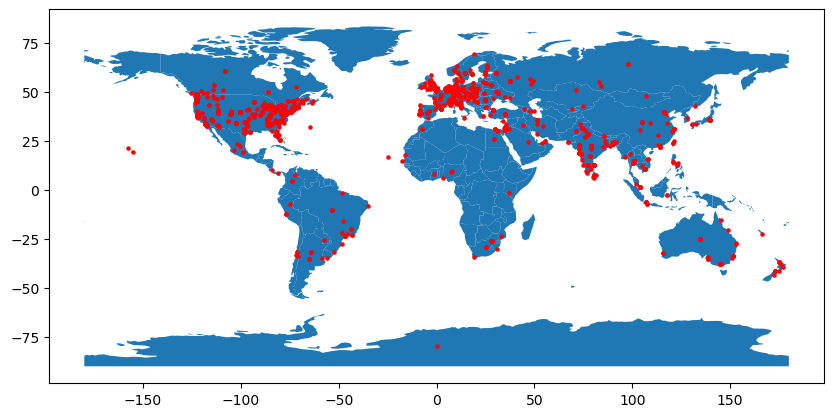

In [6]:
gdf = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations.Lon, locations.Lat)) 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=5)

C:\Users\szyme\anaconda3\lib\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique values in array to form 10 classes. Setting k to 9.
  warnings.warn(


<AxesSubplot:>

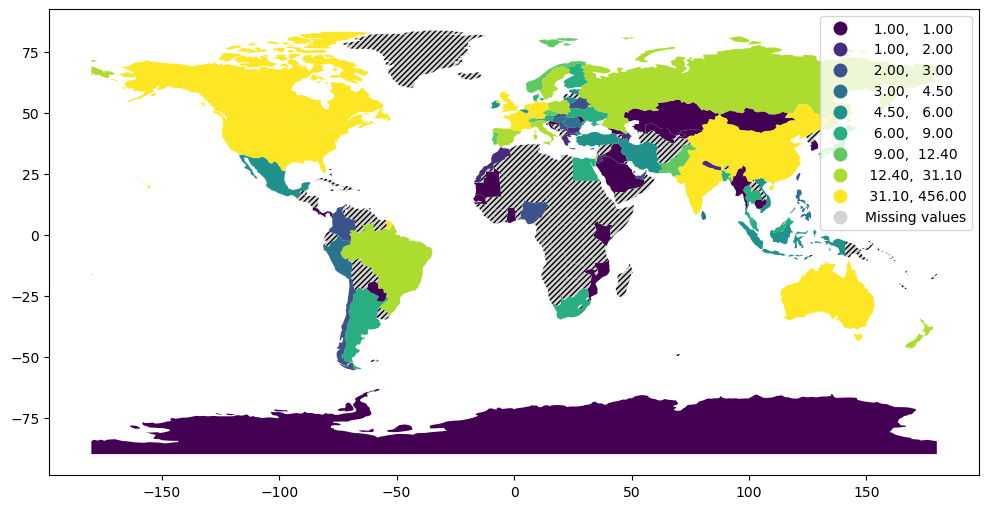

In [12]:
gdf = gdf[gdf.is_valid]
gdf.set_crs(epsg=4326, inplace=True)
result = gpd.sjoin(gdf, world, how='left')

result = pd.DataFrame(result.groupby(['iso_a3'])['iso_a3'].count())
result = result.rename(columns={"iso_a3": "count"})


fig, ax = plt.subplots(figsize=(12, 10))

world_w_counter = world.join(result, on='iso_a3', how='left')

world_w_counter.plot(column='count', scheme='Quantiles', k=10, legend=True, ax=ax, missing_kwds={
        "color": "lightgrey",
        "hatch": "//////",
        "label": "Missing values",
    },)